<a href="https://colab.research.google.com/github/LambdaLabsML/lambda-diffusers/blob/main/notebooks/pokemon_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pokémon text to image

This notebook demonstrates inference using Stable Diffusion fine tuned on Pokémon to generate new Pokémon form text prompts. The model has been ported to Huggingface Diffusers for easier inference.

For more details about the fine tuning process and how to make your own specialised model see [this guide](https://github.com/LambdaLabsML/examples/tree/main/stable-diffusion-finetuning).

Also see the following links for more info:

- [Lambda Diffusers](https://github.com/LambdaLabsML/lambda-diffusers)
- [Captioned Pokémon dataset](https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions)
- [Model weights in Diffusers format](https://huggingface.co/lambdalabs/sd-pokemon-diffusers)
- [Original model weights](https://huggingface.co/justinpinkney/pokemon-stable-diffusion)
- [Training code](https://github.com/justinpinkney/stable-diffusion)

Created by Justin Pinkney at [Lambda Labs](https://lambdalabs.com/)

In [1]:
!nvidia-smi

Tue Sep 20 10:53:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install diffusers==0.3.0
!pip install transformers scipy ftfy

In [ ]:
import torch
from diffusers import StableDiffusionPipeline
from torch import autocast

pipe = StableDiffusionPipeline.from_pretrained("lambdalabs/sd-pokemon-diffusers", torch_dtype=torch.float16)  
pipe = pipe.to("cuda")

In [33]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

  0%|          | 0/51 [00:00<?, ?it/s]

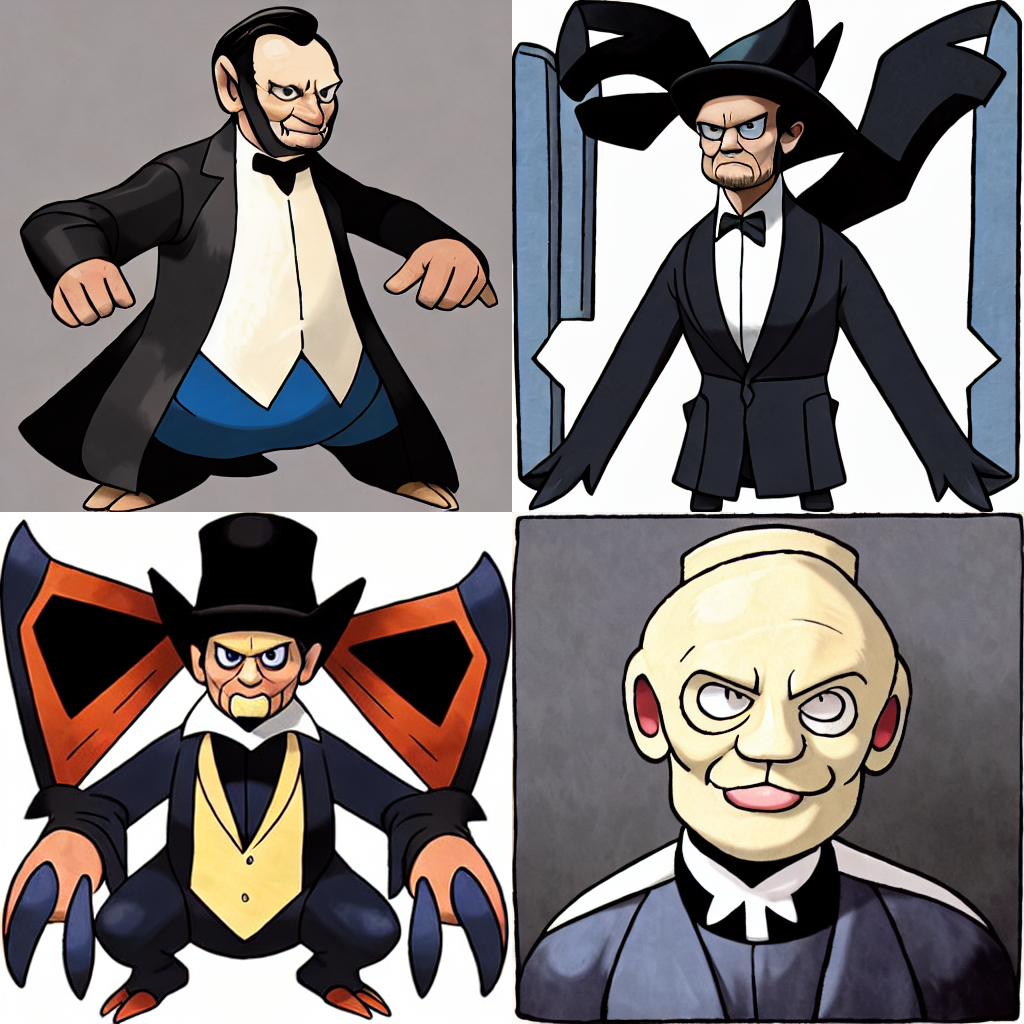

In [41]:
prompt = "Abraham Lincoln"
scale = 10
n_samples = 4

# Sometimes the nsfw checker is confused by the Pokémon images, you can disable
# it at your own risk here
disable_safety = False

if disable_safety:
  def null_safety(images, **kwargs):
      return images, False
  pipe.safety_checker = null_safety

with autocast("cuda"):
  images = pipe(n_samples*[prompt], guidance_scale=scale).images

grid = image_grid(images, rows=2, cols=2)
grid